## Data Dictionary

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## Model Building and Evaluation Metrics
Applied Machine learning models

1. Logistic Regressin
2. Multinomial Naive Bayes
3. RandomForestClassifier
4. XGBClassifier


Since this is a binary classification problem, we could use the following 2 popular metrics:

1. Confusion matrix, Precision matrix, Recall matrix
2. f1_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading Packages

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import matplotlib.pylab as plt
import matplotlib
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn_evaluation import plot
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## 1. Loading Data

In [7]:
df= pd.read_csv("/content/drive/MyDrive/Internship Task/Fraud.csv")

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df=df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})

In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
df.shape

(6362620, 11)

In [12]:
# drop Duplicates
df.drop_duplicates(inplace=True)

In [13]:
# datatypes of each attribute

df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrig    float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [14]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Number of data points in class 0 : 6354407 ( 99.871 %)
Number of data points in class 1 : 8213 ( 0.129 %)
--------------------------------------------------------------------------------


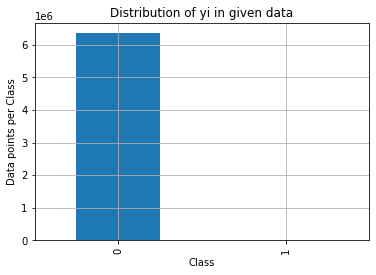

In [15]:
# originally fraud happened

df_class_distribution = df['isFraud'].value_counts().sort_index()

sorted_yi = np.argsort(-df_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',df_class_distribution.values[i], '(', np.round((df_class_distribution.values[i]/df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
df_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in given data')
plt.grid()
plt.show()

Number of data points in class 0 : 6362604 ( 100.0 %)
Number of data points in class 1 : 16 ( 0.0 %)
--------------------------------------------------------------------------------


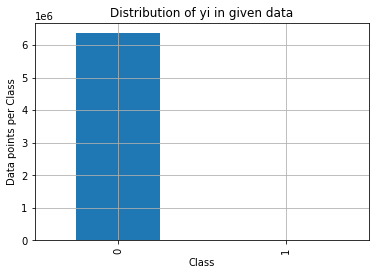

In [16]:
# isFlaggedFraud thinks there is a fraud

df_class_distribution = df['isFlaggedFraud'].value_counts().sort_index()

sorted_yi = np.argsort(-df_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',df_class_distribution.values[i], '(', np.round((df_class_distribution.values[i]/df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
df_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in given data')
plt.grid()
plt.show()

In [17]:
# describe properties of continuous features

df.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


#### Corelation matrix

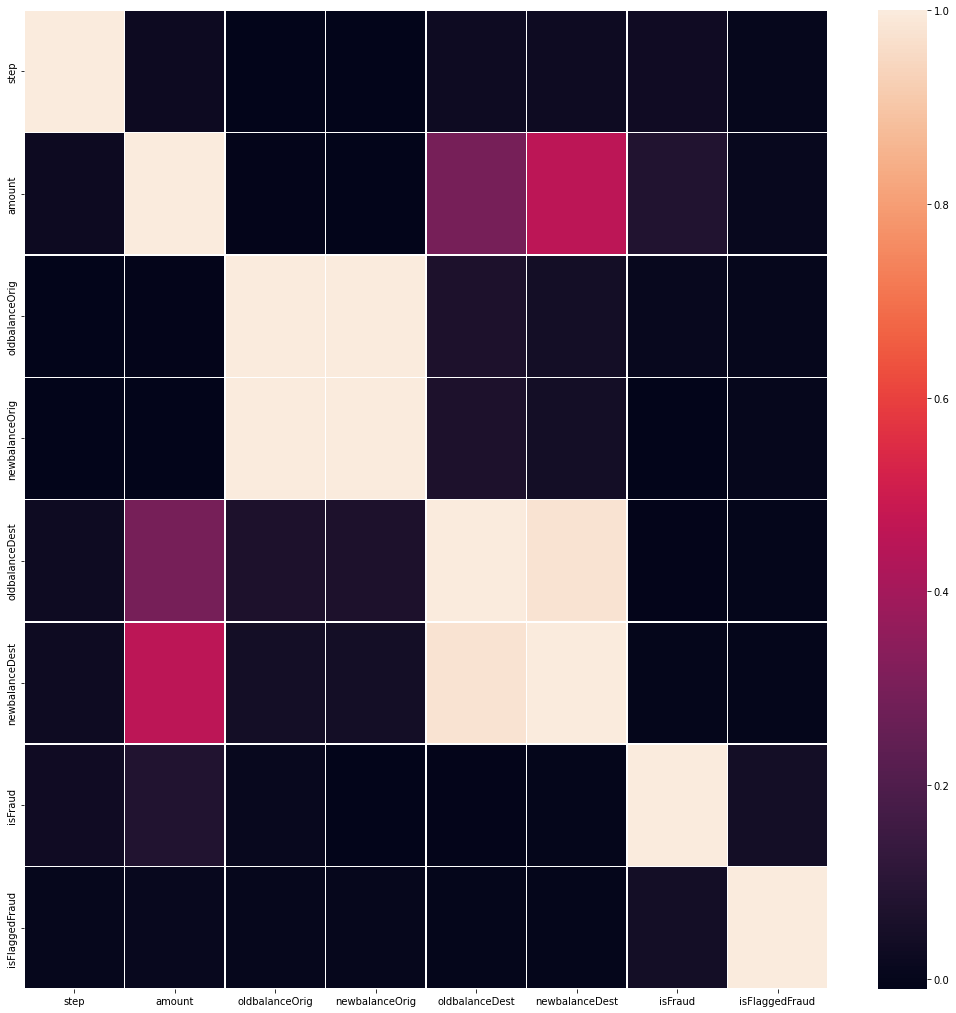

In [18]:
f,ax = plt.subplots(figsize=(18, 18))
corr_mat = sns.heatmap(df.corr(), annot=False, linewidths=.5, fmt= '.1f',ax=ax)

## 2. Univariate analysis

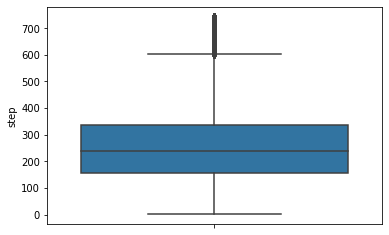

In [20]:
#Univariate analysis: step
sns.boxplot(y="step", data =df)
plt.show()

In [23]:
#calculating step values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =df["step"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 1
10 percentile value is 35
20 percentile value is 135
30 percentile value is 166
40 percentile value is 206
50 percentile value is 239
60 percentile value is 281
70 percentile value is 323
80 percentile value is 355
90 percentile value is 399
100 percentile value is  743


In [24]:
#calculating step values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df["step"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 681
99.1 percentile value is 684
99.2 percentile value is 686
99.3 percentile value is 687
99.4 percentile value is 688
99.5 percentile value is 690
99.6 percentile value is 691
99.7 percentile value is 692
99.8 percentile value is 695
99.9 percentile value is 710
100 percentile value is  743


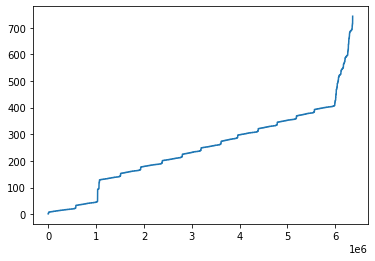

In [25]:
plt.plot(var[:-2])
plt.show()

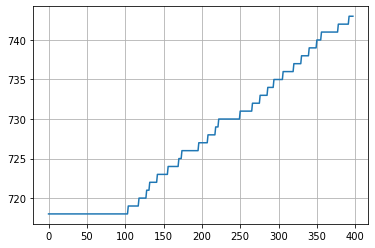

In [26]:
plt.plot(var[-400:-2])
plt.grid()
plt.show()

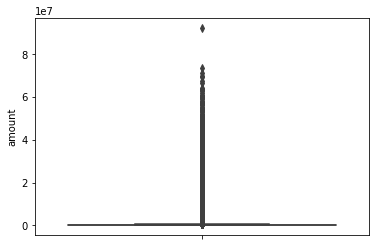

In [27]:
#Univariate analysis: amount
sns.boxplot(y="amount", data =df)
plt.show()

In [28]:
#calculating amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =df["amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 4501.3
20 percentile value is 9866.16
30 percentile value is 18092.04
40 percentile value is 36371.37
50 percentile value is 74872.08
60 percentile value is 122563.82
70 percentile value is 176802.01
80 percentile value is 246611.46
90 percentile value is 365423.48
100 percentile value is  92445516.64


In [29]:
#calculating amount values at each percntile 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
for i in np.arange(0.0, 1.1, 0.1):
    var =df["amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(round(0+i,1) ,var[int(len(var)*(float(0+i)/100))]))
#print("10 percentile value is ",var[-1])

0.0 percentile value is 0.0
0.1 percentile value is 44.8
0.2 percentile value is 90.29
0.3 percentile value is 135.5
0.4 percentile value is 180.53
0.5 percentile value is 224.97
0.6 percentile value is 270.16
0.7 percentile value is 314.92
0.8 percentile value is 360.05
0.9 percentile value is 404.74
1.0 percentile value is 449.46


In [30]:
#calculating amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df["amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 1615983.34
99.1 percentile value is 1723316.32
99.2 percentile value is 1850389.76
99.3 percentile value is 2002993.66
99.4 percentile value is 2189828.78
99.5 percentile value is 2437749.43
99.6 percentile value is 2793739.8
99.7 percentile value is 3365587.84
99.8 percentile value is 4566847.18
99.9 percentile value is 8959364.15
100 percentile value is  92445516.64


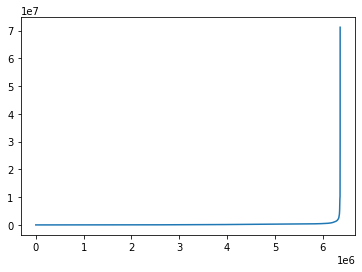

In [31]:
plt.plot(var[:-2])
plt.show()

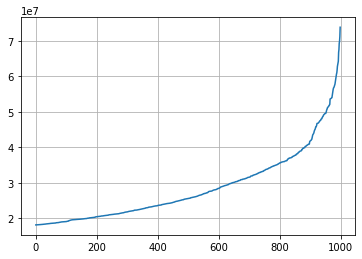

In [32]:
plt.plot(var[-1000:-1])
plt.grid()
plt.show()

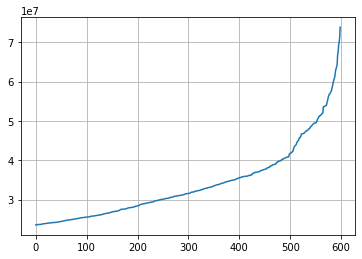

In [33]:
plt.plot(var[-600:-1])
plt.grid()
plt.show()

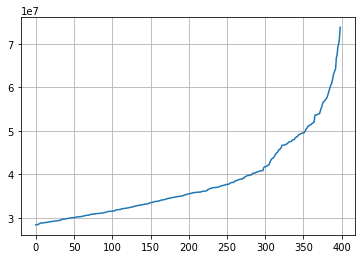

In [34]:
plt.plot(var[-400:-1])
plt.grid()
plt.show()

In [35]:
#Univariate analysis: type

df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

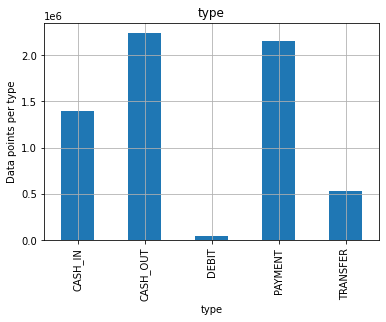

In [36]:
#Univariate analysis: type

occupation_distribution = df['type'].value_counts().sort_index()

my_colors = 'rgbkymc'
occupation_distribution.plot(kind='bar')
plt.xlabel('type')
plt.ylabel('Data points per type')
plt.title('type')
plt.grid()
plt.show()


In [37]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [38]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrig    float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [39]:
df['nameOrig'].value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

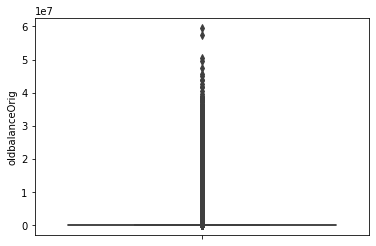

In [40]:
#Univariate analysis: oldbalanceOrig
sns.boxplot(y="oldbalanceOrig", data =df)
plt.show()

In [41]:
#Univariate analysis: oldbalanceOrig

#calculating oldbalanceOrg values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =df["oldbalanceOrig"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 2344.0
50 percentile value is 14208.0
60 percentile value is 30776.0
70 percentile value is 69499.0
80 percentile value is 198632.0
90 percentile value is 1822519.8
100 percentile value is  59585040.37


In [42]:
#calculating oldbalanceOrig values at each percntile 30.0,30.1,30.2,30.3,30.4,30.5,30.6,30.7,30.8,30.9,40.0
for i in np.arange(30.0, 40.1, 0.5):
    var =df["oldbalanceOrig"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(round(0+i,1) ,var[int(len(var)*(float(0+i)/100))]))
#print("10 percentile value is ",var[-1])

30.0 percentile value is 0.0
30.5 percentile value is 0.0
31.0 percentile value is 0.0
31.5 percentile value is 0.0
32.0 percentile value is 0.0
32.5 percentile value is 0.0
33.0 percentile value is 0.0
33.5 percentile value is 87.0
34.0 percentile value is 132.0
34.5 percentile value is 168.0
35.0 percentile value is 212.0
35.5 percentile value is 278.0
36.0 percentile value is 371.0
36.5 percentile value is 483.0
37.0 percentile value is 589.29
37.5 percentile value is 736.0
38.0 percentile value is 912.0
38.5 percentile value is 1085.0
39.0 percentile value is 1387.0
39.5 percentile value is 1869.0
40.0 percentile value is 2344.0


In [43]:
#calculating oldbalanceOrig values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df["oldbalanceOrig"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 16027262.74
99.1 percentile value is 16840426.88
99.2 percentile value is 17698483.15
99.3 percentile value is 18604755.85
99.4 percentile value is 19591046.21
99.5 percentile value is 20675615.17
99.6 percentile value is 21885206.52
99.7 percentile value is 23209613.51
99.8 percentile value is 24762536.25
99.9 percentile value is 26825980.74
100 percentile value is  59585040.37


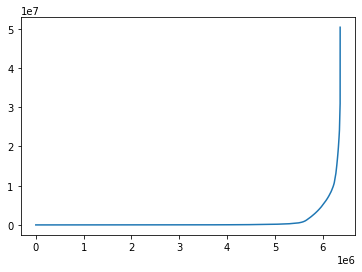

In [44]:
plt.plot(var[:-2])
plt.show()

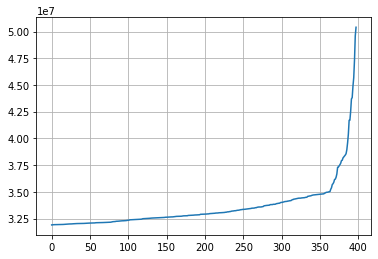

In [45]:
plt.plot(var[-400:-2])
plt.grid()
plt.show()

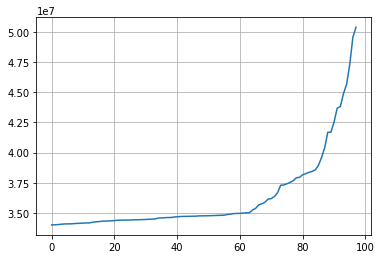

In [46]:
plt.plot(var[-100:-2])
plt.grid()
plt.show()

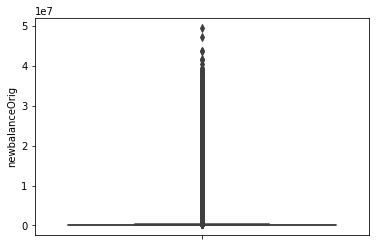

In [47]:
#Univariate analysis: newbalanceOrig
sns.boxplot(y="newbalanceOrig", data =df)
plt.show()

In [48]:
#Univariate analysis: newbalanceOrig

#calculating newbalanceOrig values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =df["newbalanceOrig"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 0.0
60 percentile value is 9741.98
70 percentile value is 76452.84
80 percentile value is 246708.2
90 percentile value is 1970345.9
100 percentile value is  49585040.37


In [49]:
#calculating newbalanceOrig values at each percntile 50.0,50.1,50.2,50.3,50.4,50.5,50.6,50.7,50.8,50.9,60.0
for i in np.arange(50.0, 60.1, 0.5):
    var =df["newbalanceOrig"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(round(0+i,1) ,var[int(len(var)*(float(0+i)/100))]))
#print("10 percentile value is ",var[-1])

50.0 percentile value is 0.0
50.5 percentile value is 0.0
51.0 percentile value is 0.0
51.5 percentile value is 0.0
52.0 percentile value is 0.0
52.5 percentile value is 0.0
53.0 percentile value is 0.0
53.5 percentile value is 0.0
54.0 percentile value is 0.0
54.5 percentile value is 0.0
55.0 percentile value is 0.0
55.5 percentile value is 0.0
56.0 percentile value is 0.0
56.5 percentile value is 0.0
57.0 percentile value is 669.13
57.5 percentile value is 2111.15
58.0 percentile value is 3614.55
58.5 percentile value is 5108.52
59.0 percentile value is 6648.0
59.5 percentile value is 8197.17
60.0 percentile value is 9741.98


In [50]:
#calculating newbalanceOrig values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df["newbalanceOrig"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 16176164.13
99.1 percentile value is 16998121.86
99.2 percentile value is 17848561.89
99.3 percentile value is 18758888.48
99.4 percentile value is 19740788.1
99.5 percentile value is 20826738.43
99.6 percentile value is 22031141.86
99.7 percentile value is 23366882.66
99.8 percentile value is 24913747.44
99.9 percentile value is 26971725.12
100 percentile value is  49585040.37


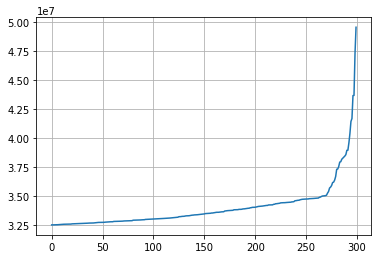

In [51]:
plt.plot(var[-300:])
plt.grid()
plt.show()

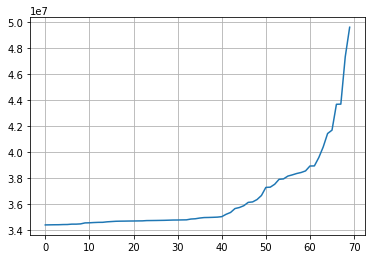

In [52]:
plt.plot(var[-70:])
plt.grid()
plt.show()

# last 30 data points might be outlier

In [53]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrig    float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [54]:
df['nameDest'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

In [55]:
len(df['nameDest'].unique())

2722362

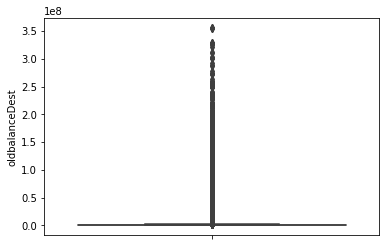

In [56]:
#Univariate analysis: oldbalanceDest
sns.boxplot(y="oldbalanceDest", data =df)
plt.show()

In [57]:
#Univariate analysis: oldbalanceDest

#calculating oldbalanceDest values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =df["oldbalanceDest"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 132705.81
60 percentile value is 343632.19
70 percentile value is 677101.8
80 percentile value is 1322204.87
90 percentile value is 2914269.63
100 percentile value is  356015889.35


In [58]:
#calculating oldbalanceDest values at each percntile 40.0,40.1,40.2,40.3,40.4,40.5,40.6,40.7,40.8,40.9,40.0
for i in np.arange(40.0, 50.1, 0.5):
    var =df["oldbalanceDest"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(round(0+i,1) ,var[int(len(var)*(float(0+i)/100))]))
#print("10 percentile value is ",var[-1])

40.0 percentile value is 0.0
40.5 percentile value is 0.0
41.0 percentile value is 0.0
41.5 percentile value is 0.0
42.0 percentile value is 0.0
42.5 percentile value is 0.0
43.0 percentile value is 6178.78
43.5 percentile value is 13504.32
44.0 percentile value is 21352.84
44.5 percentile value is 30001.24
45.0 percentile value is 38754.72
45.5 percentile value is 48038.18
46.0 percentile value is 57034.0
46.5 percentile value is 66536.59
47.0 percentile value is 76041.57
47.5 percentile value is 85480.97
48.0 percentile value is 95067.27
48.5 percentile value is 104203.19
49.0 percentile value is 113559.77
49.5 percentile value is 123220.78
50.0 percentile value is 132705.81


In [59]:
#calculating oldbalanceDest values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df["oldbalanceDest"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 12371824.68
99.1 percentile value is 12905312.04
99.2 percentile value is 13555672.44
99.3 percentile value is 14377095.08
99.4 percentile value is 15509875.27
99.5 percentile value is 17001241.93
99.6 percentile value is 19296656.64
99.7 percentile value is 22452843.64
99.8 percentile value is 26949078.46
99.9 percentile value is 34393287.2
100 percentile value is  356015889.35


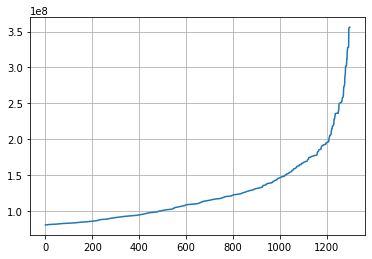

In [60]:
plt.plot(var[-1300:])
plt.grid()
plt.show()

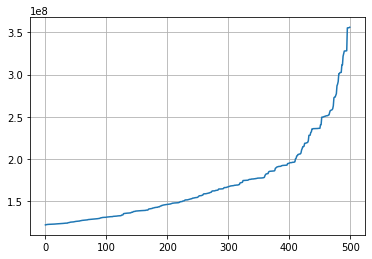

In [61]:
plt.plot(var[-500:])
plt.grid()
plt.show()

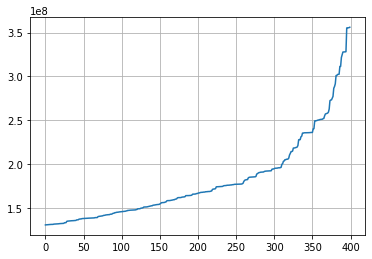

In [62]:
plt.plot(var[-400:])
plt.grid()
plt.show()

# last 100 dada points might be outliers

In [63]:
var[-300]

146082977.86

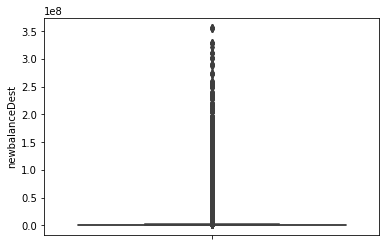

In [64]:
#Univariate analysis: newbalanceDest
sns.boxplot(y="newbalanceDest", data =df)
plt.show()

In [65]:
#Univariate analysis: newbalanceDest

#calculating newbalanceDest values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =df["newbalanceDest"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 31563.6
50 percentile value is 214661.65
60 percentile value is 445931.49
70 percentile value is 823679.73
80 percentile value is 1517364.33
90 percentile value is 3194873.19
100 percentile value is  356179278.92


In [66]:
#calculating newbalanceDest values at each percntile 30.0 30.5 31.0 31.5 32.0 32.5 33.0 33.5 34.0 34.5 35.0 35.5 36.0 36.5 37.0 37.5 38.0 38.5 39.0 39.5 40.0 
for i in np.arange(30.0, 40.1, 0.5):
    var =df["newbalanceDest"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(round(0+i,1) ,var[int(len(var)*(float(0+i)/100))]))
#print("10 percentile value is ",var[-1])

30.0 percentile value is 0.0
30.5 percentile value is 0.0
31.0 percentile value is 0.0
31.5 percentile value is 0.0
32.0 percentile value is 0.0
32.5 percentile value is 0.0
33.0 percentile value is 0.0
33.5 percentile value is 0.0
34.0 percentile value is 0.0
34.5 percentile value is 0.0
35.0 percentile value is 0.0
35.5 percentile value is 0.0
36.0 percentile value is 0.0
36.5 percentile value is 0.0
37.0 percentile value is 0.0
37.5 percentile value is 0.0
38.0 percentile value is 0.0
38.5 percentile value is 3210.39
39.0 percentile value is 12805.07
39.5 percentile value is 22190.99
40.0 percentile value is 31563.6


In [67]:
for i in np.arange(30.0, 40.1, 0.5):
    print(i,end=" ")

30.0 30.5 31.0 31.5 32.0 32.5 33.0 33.5 34.0 34.5 35.0 35.5 36.0 36.5 37.0 37.5 38.0 38.5 39.0 39.5 40.0 

In [68]:
#calculating newbalanceDest values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df["newbalanceDest"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 13137915.03
99.1 percentile value is 13743729.83
99.2 percentile value is 14497045.37
99.3 percentile value is 15484884.29
99.4 percentile value is 16688154.1
99.5 percentile value is 18378274.44
99.6 percentile value is 20936997.59
99.7 percentile value is 24446741.54
99.8 percentile value is 29003469.5
99.9 percentile value is 39535617.9
100 percentile value is  356179278.92


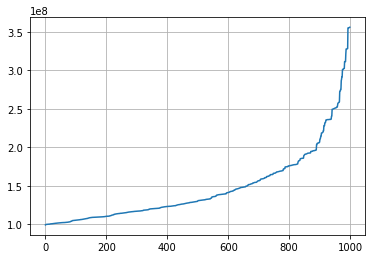

In [69]:
plt.plot(var[-1000:])
plt.grid()
plt.show()

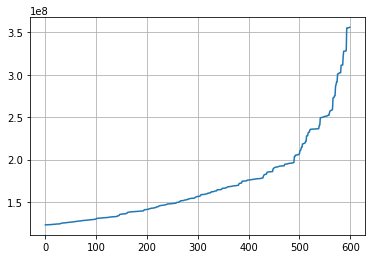

In [70]:
plt.plot(var[-600:])
plt.grid()
plt.show()

# last 200 data points might be outlier

In [71]:
var[-400]

141093012.46

In [72]:
# Probability distribution

# df.plot(kind="density", layout=(6,5), 
             # subplots=True,sharex=False, sharey=False, figsize=(18,18))
# plt.show()

## 3. Bivariate analysis

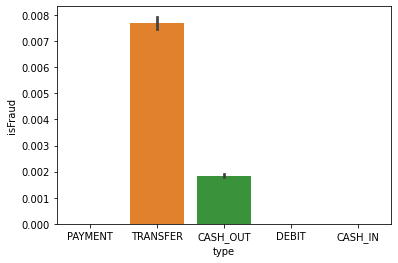

In [73]:
# Plots used are: bar plot and count plot
sns.barplot(x='type',y='isFraud',data=df)

# is the type is TRANSFER there is high chance of Fraud

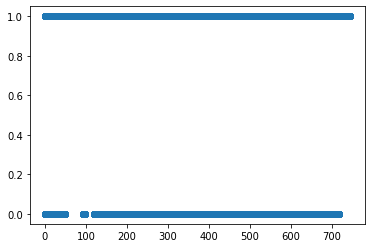

In [74]:
%matplotlib inline
plt.scatter(x= df['step'] , y= df['isFraud'])

## 3. Analysis with multiple variable

In [75]:
mv1= (((df.loc[(df['isFraud']==1) & (df['newbalanceOrig']==0.0)]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if newbalanceOrig=0.0 there is ",np.round(mv1,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if newbalanceOrig=0.0 there is  98.05 % chance of is_Fraud=1 given total number of is_Fraud=1


In [76]:
mv2= (((df.loc[(df['isFraud']==1) & (df['oldbalanceOrig']==0.0)]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if oldbalanceOrig=0.0 there is ",np.round(mv2,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if oldbalanceOrig=0.0 there is  0.5 % chance of is_Fraud=1 given total number of is_Fraud=1


In [77]:
mv3= (((df.loc[(df['isFraud']==1) & (df['oldbalanceDest']==0.0)]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if oldbalanceDest=0.0 there is ",np.round(mv3,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if oldbalanceDest=0.0 there is  65.15 % chance of is_Fraud=1 given total number of is_Fraud=1


In [78]:
mv4= (((df.loc[(df['isFraud']==1) & (df['newbalanceDest']==0.0)]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if newbalanceDest=0.0 there is ",np.round(mv4,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if newbalanceDest=0.0 there is  49.81 % chance of is_Fraud=1 given total number of is_Fraud=1


In [79]:
mv5= (((df.loc[(df['isFraud']==1) & (df['type']=='TRANSFER')]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if type=TRANSFER there is ",np.round(mv5,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if type=TRANSFER there is  49.88 % chance of is_Fraud=1 given total number of is_Fraud=1


In [80]:
mv6= (((df.loc[(df['isFraud']==1) & (df['type']=='CASH_OUT')]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if type=CASH_OUT there is ",np.round(mv6,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if type=CASH_OUT there is  50.12 % chance of is_Fraud=1 given total number of is_Fraud=1


In [81]:
mv7= (((df.loc[(df['isFraud']==1) & (df['type']=='PAYMENT')]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if type=PAYMENT there is ",np.round(mv7,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if type=PAYMENT there is  0.0 % chance of is_Fraud=1 given total number of is_Fraud=1


In [82]:
mv8= (((df.loc[(df['isFraud']==1) & (df['type']=='CASH_IN')]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if type=CASH_IN there is ",np.round(mv8,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if type=CASH_IN there is  0.0 % chance of is_Fraud=1 given total number of is_Fraud=1


In [83]:
mv9= (((df.loc[(df['isFraud']==1) & (df['type']=='DEBIT')]).value_counts().sum())/
      ((df[df['isFraud']==1]).value_counts().sum()))*100

print("if type=DEBIT there is ",np.round(mv9,2),"% chance of is_Fraud=1 given total number of is_Fraud=1")

if type=DEBIT there is  0.0 % chance of is_Fraud=1 given total number of is_Fraud=1


> <b> Based on above EDA(Exploratory Data Analysis) we can see that if 'newbalanceOrig'=0.0 or 'oldbalanceDest'=0.0 or type='CASH_OUT' OR type='TRANSFER' there might be high chance of isFraud=1 <b>

## 4. Outlier treatment

In [84]:
#removing all outliers based on our univariate analysis above

def outlier_treatment(new_frame):

    a = new_frame.shape[0]
    print ("Number of records = ",a)
    temp_frame = new_frame[((new_frame.amount >= 0.0) & (new_frame.amount <= 40000000.0))]
    b = temp_frame.shape[0]
    print ("Number of outliers from amount analysis:",(a-b))
    
    
    temp_frame = new_frame[(new_frame.oldbalanceOrig >= 0.0) & (new_frame.oldbalanceOrig <= 30000000.0)]
    c = temp_frame.shape[0]
    print ("Number of outliers from oldbalanceOrig analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.newbalanceOrig >= 0.0) & (new_frame.newbalanceOrig <= 34000000.0)]
    d = temp_frame.shape[0]
    print ("Number of outliers from newbalanceOrig analysis:",(a-d))
    
    
    temp_frame = new_frame[(new_frame.oldbalanceDest >= 0.0) & (new_frame.oldbalanceDest <= 140000000.0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from oldbalanceDest analysis:",(a-e))
    

    temp_frame = new_frame[(new_frame.newbalanceDest >= 0.0) & (new_frame.newbalanceDest <= 140000000.0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from newbalanceDest analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.amount >= 0.0) & (new_frame.amount <= 40000000.0))]
    new_frame = new_frame[(new_frame.oldbalanceOrig >= 0.0) & (new_frame.oldbalanceOrig <= 30000000.0)]
    new_frame = new_frame[(new_frame.newbalanceOrig >= 0.0) & (new_frame.newbalanceOrig <= 34000000.0)]
    new_frame = new_frame[(new_frame.oldbalanceDest >= 0.0) & (new_frame.oldbalanceDest <= 140000000.0)]
    new_frame = new_frame[(new_frame.newbalanceDest >= 0.0) & (new_frame.newbalanceDest <= 140000000.0)]

    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [85]:
print ("Removing outliers")
print ("----")
frame_with_outliers_removed = outlier_treatment(df)
print("fraction of data points that remain after removing outliers", float(len(frame_with_outliers_removed))/len(df))

Removing outliers
----
Number of records =  6362620
Number of outliers from amount analysis: 117
Number of outliers from oldbalanceOrig analysis: 1289
Number of outliers from newbalanceOrig analysis: 103
Number of outliers from oldbalanceDest analysis: 331
Number of outliers from newbalanceDest analysis: 406
Total outliers removed 1765
---
fraction of data points that remain after removing outliers 0.9997225985521687


In [86]:
frame_with_outliers_removed.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 5. Feature engineering

In [87]:
# check clearly where the exact fraud has happened

(frame_with_outliers_removed[frame_with_outliers_removed['isFraud'] == 1]).head(30)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.00,C339924917,6268.00,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.00,C667346055,102.00,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.00,C716083600,0.00,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.00,C1136419747,0.00,0.00,1,0


> <b>Here we can see that some nameOrig has less amount on his/her oldbalanceOrg than amount that want to transfer(e.g row number 724, 1911)</b>

In [133]:
def addFeatures(frame):
    frame['amount_deduct_from_Orig'] = frame['oldbalanceOrig'] - frame['newbalanceOrig']
    frame['amount_expect_after_successful_transfer'] = frame['oldbalanceDest'] + frame['amount']

    return frame


In [134]:
featurization_df = addFeatures(frame_with_outliers_removed)
featurization_df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_deduct_from_Orig,amount_expect_after_successful_transfer
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,21363.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,11668.14


In [135]:
(featurization_df.loc[(featurization_df['isFraud']==1) & (featurization_df['isFlaggedFraud']==1)]).head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_deduct_from_Orig,amount_expect_after_successful_transfer
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1,0.0,4953893.08
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1,0.0,1343002.08
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1,0.0,536624.41
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1,0.0,4892193.09
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1,0.0,10000000.00


In [136]:
featurization_df[featurization_df['isFlaggedFraud']==1]

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_deduct_from_Orig,amount_expect_after_successful_transfer
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1,0.0,4953893.08
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1,0.0,1343002.08
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1,0.0,536624.41
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1,0.0,4892193.09
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1,0.0,10000000.00
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1,0.0,9585040.37
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1,0.0,3576297.10
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1,0.0,353874.22
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1,0.0,2542664.27
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1,0.0,10000000.00


In [137]:
(featurization_df[featurization_df['isFlaggedFraud']==1]).value_counts().sum()

16

## 6. Splitting data into Train and cross validation and test: Stratified Sampling

In [210]:
# for training and evaluating purpose I am taking 3% from total given data
# .sample randomly select a specified fraction of the total number of rows

featurization_df_sample = featurization_df.sample(frac= 0.03)

In [211]:
featurization_df_sample.shape

(190826, 13)

In [212]:
y = featurization_df_sample['isFraud'].values
X = featurization_df_sample.drop(['isFraud'], axis=1)
X.head(2)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,amount_deduct_from_Orig,amount_expect_after_successful_transfer
5186663,361,PAYMENT,7382.65,C1962485247,0.00,0.00,M1153601540,0.0,0.0,0,0.0,7382.65
2625844,209,PAYMENT,8203.70,C806565516,97568.31,89364.61,M1375953172,0.0,0.0,0,8203.7,8203.70


In [213]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [214]:
print("Train data ",X_train.shape, y_train.shape)
print("CV data    ",X_cv.shape, y_cv.shape)
print("Test data  ",X_test.shape, y_test.shape)

Train data  (85661, 12) (85661,)
CV data     (42192, 12) (42192,)
Test data   (62973, 12) (62973,)


## 7. Make Data Model Ready: encoding numerical, categorical features

In [215]:
X_train.dtypes

step                                         int64
type                                        object
amount                                     float64
nameOrig                                    object
oldbalanceOrig                             float64
newbalanceOrig                             float64
nameDest                                    object
oldbalanceDest                             float64
newbalanceDest                             float64
isFlaggedFraud                               int64
amount_deduct_from_Orig                    float64
amount_expect_after_successful_transfer    float64
dtype: object

### 7.1 encoding categorical features: type

In [216]:
from sklearn.feature_extraction.text import CountVectorizer

In [217]:
X_train['type'].value_counts()

CASH_OUT    30237
PAYMENT     28993
CASH_IN     18727
TRANSFER     7101
DEBIT         603
Name: type, dtype: int64

In [218]:
vectorizer = CountVectorizer()
v = vectorizer.fit(X_train['type'].values) # fit has to happen only on train data
#print(type(v))


# we use the fitted CountVectorizer to convert the text to vector
X_train_type_ohe = vectorizer.transform(X_train['type'].values)
X_cv_type_ohe = vectorizer.transform(X_cv['type'].values)
X_test_type_ohe = vectorizer.transform(X_test['type'].values)

print("After vectorizations")
print(X_train_type_ohe.shape, y_train.shape)
print(X_cv_type_ohe.shape, y_cv.shape)
print(X_test_type_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)


After vectorizations
(85661, 5) (85661,)
(42192, 5) (42192,)
(62973, 5) (62973,)
['cash_in', 'cash_out', 'debit', 'payment', 'transfer']


### 7.2 encoding categorical features: nameOrig

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

In [220]:
# https://stackoverflow.com/questions/66122577/response-coding-for-categorical-data
from prettytable import PrettyTable
from tqdm import tqdm

def response_coding(xtrain, ytrain, feature):
    
    dictionary = dict()
    x = PrettyTable()
    x = PrettyTable([feature, 'class 1', 'class 0'])

    unique_cat_labels = np.unique(xtrain[feature])

    for i in tqdm(range(len(unique_cat_labels))):
        total_count = xtrain.loc[:,feature][(xtrain[feature] == unique_cat_labels[i])].count()
        p_0 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==0))].count()
        p_1 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==1))].count()

        dictionary[unique_cat_labels[i]] = [p_1/total_count, p_0/total_count]

        row = []
        row.append(unique_cat_labels[i])
        row.append(p_1/total_count)
        row.append(p_0/total_count)
        x.add_row(row)
    #print(x)
    #print(x)[![enter image description here][1]][1]
    return dictionary

In [156]:
import os
import pickle

In [194]:
# creating sample data for response coding, othrewose to train with arount 28Million datapoint it will take too longer time

#featurization_df_sample = featurization_df.sample(n=10000, replace=False)
#sample_X = featurization_df_sample.drop(['isFraud'], axis=1)
#sample_y = featurization_df_sample['isFraud'].values

In [221]:
if not os.path.isfile('/content/drive/MyDrive/Internship Task/nameOrig.pickle'):
    nameOrig_response=response_coding(X_train, y_train, 'nameOrig')

    # Store data
    with open('/content/drive/MyDrive/Internship Task/nameOrig.pickle', 'wb') as handle:
        pickle.dump(nameOrig_response, handle, protocol=pickle.HIGHEST_PROTOCOL)


else:
    
    with open('/content/drive/MyDrive/Internship Task/nameOrig.pickle', 'rb') as handle:
        nameOrig_response = pickle.load(handle)


100%|██████████| 85657/85657 [1:40:04<00:00, 14.26it/s]


In [222]:
# response coding on X_train

nameOrig_tr_class1 = []
nameOrig_tr_class0 = []
for row_X_train in tqdm(X_train['nameOrig']):
    for row_dict in nameOrig_response:
        if row_X_train == row_dict:
            nameOrig_tr_class1.append(nameOrig_response[row_dict][0])
            nameOrig_tr_class0.append(nameOrig_response[row_dict][1])
                
#print(len(nameOrig_tr_class1))
#print(len(nameOrig_tr_class0))
#print(len(X_train))


# response coding on X_cv

nameOrig_cv_class1 = []
nameOrig_cv_class0 = []
for row_X_cv in tqdm(X_cv['nameOrig']):
    s=0
    for row_dict in nameOrig_response:
        if row_X_cv == row_dict:
            nameOrig_cv_class1.append(nameOrig_response[row_dict][0])
            nameOrig_cv_class0.append(nameOrig_response[row_dict][1])
            s=1
                
    if s!=1:
        nameOrig_cv_class1.append(0.5)
        nameOrig_cv_class0.append(0.5)
                
#print(len(nameOrig_cv_class1))
#print(len(nameOrig_cv_class0))
#print(len(X_cv))



# response coding on X_test

nameOrig_te_class1 = []
nameOrig_te_class0 = []
for row_X_test in tqdm(X_test['nameOrig']):
    s=0
    for row_dict in nameOrig_response:
        if row_X_test == row_dict:
            nameOrig_te_class1.append(nameOrig_response[row_dict][0])
            nameOrig_te_class0.append(nameOrig_response[row_dict][1])
            s=1
                
    if s!=1:
        nameOrig_te_class1.append(0.5)
        nameOrig_te_class0.append(0.5)
                
#print(len(nameOrig_te_class1))
#print(len(nameOrig_te_class0))
#print(len(X_test))




100%|██████████| 62973/62973 [26:54<00:00, 39.00it/s]


In [226]:
len(nameOrig_cv_class0)

42192

### 7.3 encoding categorical features: nameDest

In [232]:
if not os.path.isfile('/content/drive/MyDrive/Internship Task/nameDest.pickle'):
    nameDest_response=response_coding(X_train, y_train, 'nameDest')

    # Store data
    with open('/content/drive/MyDrive/Internship Task/nameDest.pickle', 'wb') as handle:
        pickle.dump(nameDest_response, handle, protocol=pickle.HIGHEST_PROTOCOL)


else:
    
    with open('/content/drive/MyDrive/Internship Task/nameDest.pickle', 'rb') as handle:
        nameDest_response = pickle.load(handle)


100%|██████████| 80238/80238 [1:29:38<00:00, 14.92it/s]


In [234]:
# response coding on X_train

nameDest_tr_class1 = []
nameDest_tr_class0 = []
for row_X_train in tqdm(X_train['nameDest']):
    for row_dict in nameDest_response:
        if row_X_train == row_dict:
            nameDest_tr_class1.append(nameDest_response[row_dict][0])
            nameDest_tr_class0.append(nameDest_response[row_dict][1])
            
#print(len(nameDest_tr_class1))
#print(len(nameDest_tr_class0))
#print(len(X_train))


# response coding on X_cv

nameDest_cv_class1 = []
nameDest_cv_class0 = []
for row_X_cv in tqdm(X_cv['nameDest']):
    s=0
    for row_dict in nameDest_response:
        if row_X_cv == row_dict:
            nameDest_cv_class1.append(nameDest_response[row_dict][0])
            nameDest_cv_class0.append(nameDest_response[row_dict][1])
            s=1
            
    if s!=1:
        nameDest_cv_class1.append(0.5)
        nameDest_cv_class0.append(0.5)
            
#print(len(nameDest_cv_class1))
#print(len(nameDest_cv_class0))
#print(len(X_cv))



# response coding on X_test

nameDest_te_class1 = []
nameDest_te_class0 = []
for row_X_test in tqdm(X_test['nameDest']):
    s=0
    for row_dict in nameDest_response:
        if row_X_test == row_dict:
            nameDest_te_class1.append(nameDest_response[row_dict][0])
            nameDest_te_class0.append(nameDest_response[row_dict][1])
            s=1
            
    if s!=1:
        nameDest_te_class1.append(0.5)
        nameDest_te_class0.append(0.5)
            
#print(len(nameDest_te_class1))
#print(len(nameDest_te_class0))
#print(len(X_test))

100%|██████████| 62973/62973 [24:19<00:00, 43.16it/s]


In [235]:
len(nameDest_cv_class0)

42192

### 7.4 encoding numerical features: amount

In [236]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()

norm.fit(X_train['amount'].values.reshape(-1,1))

X_train_amount_norm = norm.transform(X_train['amount'].values.reshape(-1,1))
X_cv_amount_norm = norm.transform(X_cv['amount'].values.reshape(-1,1))
X_test_amount_norm = norm.transform(X_test['amount'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_amount_norm.shape, y_train.shape)
print(X_cv_amount_norm.shape, y_cv.shape)
print(X_test_amount_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(85661, 1) (85661,)
(42192, 1) (42192,)
(62973, 1) (62973,)


### 7.5 encoding numerical features: oldbalanceOrig

In [237]:
norm = Normalizer()

norm.fit(X_train['oldbalanceOrig'].values.reshape(-1,1))

X_train_oldbalanceOrig_norm = norm.transform(X_train['oldbalanceOrig'].values.reshape(-1,1))
X_cv_oldbalanceOrig_norm = norm.transform(X_cv['oldbalanceOrig'].values.reshape(-1,1))
X_test_oldbalanceOrig_norm = norm.transform(X_test['oldbalanceOrig'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_oldbalanceOrig_norm.shape, y_train.shape)
print(X_cv_oldbalanceOrig_norm.shape, y_cv.shape)
print(X_test_oldbalanceOrig_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(85661, 1) (85661,)
(42192, 1) (42192,)
(62973, 1) (62973,)


### 7.6 encoding numerical features: newbalanceOrig

In [238]:
norm = Normalizer()

norm.fit(X_train['newbalanceOrig'].values.reshape(-1,1))

X_train_newbalanceOrig_norm = norm.transform(X_train['newbalanceOrig'].values.reshape(-1,1))
X_cv_newbalanceOrig_norm = norm.transform(X_cv['newbalanceOrig'].values.reshape(-1,1))
X_test_newbalanceOrig_norm = norm.transform(X_test['newbalanceOrig'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_newbalanceOrig_norm.shape, y_train.shape)
print(X_cv_newbalanceOrig_norm.shape, y_cv.shape)
print(X_test_newbalanceOrig_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(85661, 1) (85661,)
(42192, 1) (42192,)
(62973, 1) (62973,)


### 7.7 encoding numerical features: oldbalanceDest

In [239]:
norm = Normalizer()

norm.fit(X_train['oldbalanceDest'].values.reshape(-1,1))

X_train_oldbalanceDest_norm = norm.transform(X_train['oldbalanceDest'].values.reshape(-1,1))
X_cv_oldbalanceDest_norm = norm.transform(X_cv['oldbalanceDest'].values.reshape(-1,1))
X_test_oldbalanceDest_norm = norm.transform(X_test['oldbalanceDest'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_oldbalanceDest_norm.shape, y_train.shape)
print(X_cv_oldbalanceDest_norm.shape, y_cv.shape)
print(X_test_oldbalanceDest_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(85661, 1) (85661,)
(42192, 1) (42192,)
(62973, 1) (62973,)


### 7.8 encoding numerical features: newbalanceDest 

In [240]:
norm = Normalizer()

norm.fit(X_train['newbalanceDest'].values.reshape(-1,1))

X_train_newbalanceDest_norm = norm.transform(X_train['newbalanceDest'].values.reshape(-1,1))
X_cv_newbalanceDest_norm = norm.transform(X_cv['newbalanceDest'].values.reshape(-1,1))
X_test_newbalanceDest_norm = norm.transform(X_test['newbalanceDest'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_newbalanceDest_norm.shape, y_train.shape)
print(X_cv_newbalanceDest_norm.shape, y_cv.shape)
print(X_test_newbalanceDest_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(85661, 1) (85661,)
(42192, 1) (42192,)
(62973, 1) (62973,)


### 7.9 encoding numerical features: amount_deduct_from_Orig




In [241]:
norm = Normalizer()

norm.fit(X_train['amount_deduct_from_Orig'].values.reshape(-1,1))

X_train_amount_deduct_from_Orig_norm = norm.transform(X_train['amount_deduct_from_Orig'].values.reshape(-1,1))
X_cv_amount_deduct_from_Orig_norm = norm.transform(X_cv['amount_deduct_from_Orig'].values.reshape(-1,1))
X_test_amount_deduct_from_Orig_norm = norm.transform(X_test['amount_deduct_from_Orig'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_amount_deduct_from_Orig_norm.shape, y_train.shape)
print(X_cv_amount_deduct_from_Orig_norm.shape, y_cv.shape)
print(X_test_amount_deduct_from_Orig_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(85661, 1) (85661,)
(42192, 1) (42192,)
(62973, 1) (62973,)


### 7.10 encoding numerical features: amount_expect_after_successful_transfer




In [242]:
norm = Normalizer()

norm.fit(X_train['amount_expect_after_successful_transfer'].values.reshape(-1,1))

X_train_amount_expect_after_successful_transfer_norm = norm.transform(X_train['amount_expect_after_successful_transfer'].values.reshape(-1,1))
X_cv_amount_expect_after_successful_transfer_norm = norm.transform(X_cv['amount_expect_after_successful_transfer'].values.reshape(-1,1))
X_test_amount_expect_after_successful_transfer_norm = norm.transform(X_test['amount_expect_after_successful_transfer'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_amount_expect_after_successful_transfer_norm.shape, y_train.shape)
print(X_cv_amount_expect_after_successful_transfer_norm.shape, y_cv.shape)
print(X_test_amount_expect_after_successful_transfer_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(85661, 1) (85661,)
(42192, 1) (42192,)
(62973, 1) (62973,)


## 8. Concatinating all the features(categorical, numerical features)

In [243]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039

from scipy.sparse import hstack
X_tr = hstack((np.array(X_train['step']).reshape(-1,1), X_train_type_ohe, X_train_amount_norm, np.array(nameOrig_tr_class1).reshape(-1,1), 
              np.array(nameOrig_tr_class0).reshape(-1,1), X_train_oldbalanceOrig_norm, X_train_newbalanceOrig_norm,
              np.array(nameDest_tr_class1).reshape(-1,1), np.array(nameOrig_tr_class0).reshape(-1,1),
              X_train_oldbalanceDest_norm, X_train_newbalanceDest_norm, np.array(X_train['isFlaggedFraud']).reshape(-1,1), X_train_amount_deduct_from_Orig_norm,
              X_train_amount_expect_after_successful_transfer_norm)).tocsr()


X_cr = hstack((np.array(X_cv['step']).reshape(-1,1), X_cv_type_ohe, X_cv_amount_norm, np.array(nameOrig_cv_class1).reshape(-1,1), 
              np.array(nameOrig_cv_class0).reshape(-1,1), X_cv_oldbalanceOrig_norm, X_cv_newbalanceOrig_norm,
              np.array(nameDest_cv_class1).reshape(-1,1), np.array(nameOrig_cv_class0).reshape(-1,1),
              X_cv_oldbalanceDest_norm, X_cv_newbalanceDest_norm, np.array(X_cv['isFlaggedFraud']).reshape(-1,1), X_cv_amount_deduct_from_Orig_norm,
              X_cv_amount_expect_after_successful_transfer_norm)).tocsr()
              

X_te = hstack((np.array(X_test['step']).reshape(-1,1), X_test_type_ohe, X_test_amount_norm, np.array(nameOrig_te_class1).reshape(-1,1), 
              np.array(nameOrig_te_class0).reshape(-1,1), X_test_oldbalanceOrig_norm, X_test_newbalanceOrig_norm,
              np.array(nameDest_te_class1).reshape(-1,1), np.array(nameOrig_te_class0).reshape(-1,1),
              X_test_oldbalanceDest_norm, X_test_newbalanceDest_norm, np.array(X_test['isFlaggedFraud']).reshape(-1,1), X_test_amount_deduct_from_Orig_norm,
              X_test_amount_expect_after_successful_transfer_norm)).tocsr()
              

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(85661, 18) (85661,)
(42192, 18) (42192,)
(62973, 18) (62973,)


## 9. Applying Machine Learning models

### 9.1 Appling Logistic Regression

#### Hyper parameter Tuning

In [244]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████| 12/12 [01:27<00:00,  7.33s/it]


C:  0.01


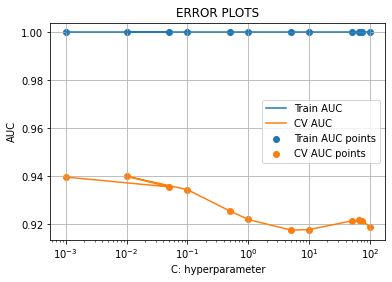

In [245]:
train_auc = []
cv_auc = []
C=[0.001,0.05,0.01,0.1,0.5,1,5,10,50, 65, 75, 100]
for i in tqdm(C):
    lr = LogisticRegression(C=i, penalty='l2', class_weight='balanced')
    lr.fit(X_tr, y_train)
    
    sig_clf = CalibratedClassifierCV(lr, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    #y_train_pred=sig_clf.predict_proba(X_tr)
    #y_cv_pred=sig_clf.predict_proba(X_cr)
    
    y_train_pred = batch_predict(sig_clf, X_tr)   
    #print(len(y_train_pred))
    y_cv_pred = batch_predict(sig_clf, X_cr)
    #print(len(y_cv_pred))
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
best_C = C[np.argmax(cv_auc)]
print("C: ", best_C)
plt.semilogx(C, train_auc, label='Train AUC')
plt.semilogx(C, cv_auc, label='CV AUC')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### tested on best hyperparameter on LogisticRegression


In [246]:
lr = LogisticRegression(C=best_C, penalty='l2', class_weight='balanced')
lr.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(lr, method="sigmoid")
sig_clf.fit(X_tr, y_train)

# f1_score for train data
train_pred = sig_clf.predict(X_tr)
train_f1_lr = f1_score(y_train, train_pred, average='weighted')
print("train f1_score: ", train_f1_lr)

# f1_score for cv data
cv_pred = sig_clf.predict(X_cr)
cv_f1_lr = f1_score(y_cv, cv_pred, average='weighted')
print("cv f1_score: ", cv_f1_lr)

# f1_score for test data
test_pred = sig_clf.predict(X_te)
test_f1_lr = f1_score(y_test, test_pred, average='weighted')
print("test f1_score: ", test_f1_lr)

train f1_score:  1.0
cv f1_score:  0.9979384704777803
test f1_score:  0.9979281607889625


#### Confusion matrix, precision matrix and recall matrix

-------------------- Confusion matrix --------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


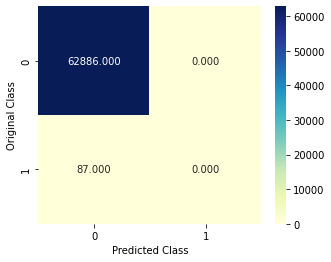

-------------------- Precision matrix (Columm Sum=1) --------------------


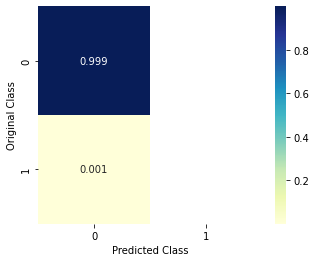

-------------------- Recall matrix (Row sum=1) --------------------


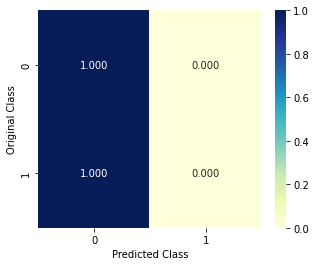

In [247]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(5,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(5,4))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(5,4))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
plot_confusion_matrix(y_test,test_pred)

### 9.2 Appling Appling Multinomial Naive Bayes

#### Hyper parameter Tuning

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best alpha for given dataset 1e-05
tested hyperparameter [1e-05 0.0001 0.001 0.1 1 10 100 1000]


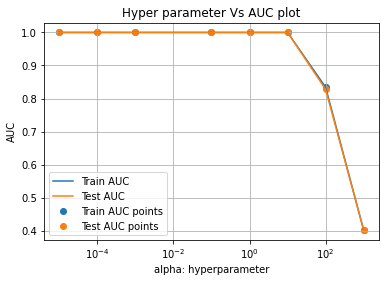

In [254]:
nb=MultinomialNB(fit_prior=True, class_prior= None)
param_grid= {"alpha": [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}


clf=GridSearchCV(nb, param_grid, cv=5, scoring='roc_auc', verbose=1, return_train_score=True)
clf.fit(abs(X_tr), y_train)
nb_hyp=clf.best_params_['alpha']
print("best alpha for given dataset",nb_hyp)
train_auc=clf.cv_results_['mean_train_score']

cv_auc=clf.cv_results_['mean_test_score'] 

alpha =  clf.cv_results_['param_alpha']
print("tested hyperparameter",alpha)

#results = pd.DataFrame.from_dict(clf.cv_results_)
#results = results.sort_values(['param_alpha'])

plt.semilogx(alpha, train_auc, label='Train AUC')

plt.semilogx(alpha, cv_auc, label='Test AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='Test AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#### tested on best hyperparameter on Multinomial Naive Bayes


In [257]:
nb = MultinomialNB(fit_prior=True, class_prior= None, alpha= nb_hyp)
nb.fit(abs(X_tr), y_train)
sig_clf = CalibratedClassifierCV(nb, method="sigmoid")
sig_clf.fit(abs(X_tr), y_train)

# f1_score for train data
train_pred = sig_clf.predict(X_tr)
train_f1_nb = f1_score(y_train, train_pred, average='weighted')
print("train f1_score: ", train_f1_nb)

# f1_score for cv data
cv_pred = sig_clf.predict(X_cr)
cv_f1_nb = f1_score(y_cv, cv_pred, average='weighted')
print("cv f1_score: ", cv_f1_nb)

# f1_score for test data
test_pred = sig_clf.predict(X_te)
test_f1_nb = f1_score(y_test, test_pred, average='weighted')
print("test f1_score: ", test_f1_nb)

train f1_score:  1.0
cv f1_score:  0.9979384704777803
test f1_score:  0.9979281607889625


#### Confusion matrix, precision matrix and recall matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


-------------------- Confusion matrix --------------------


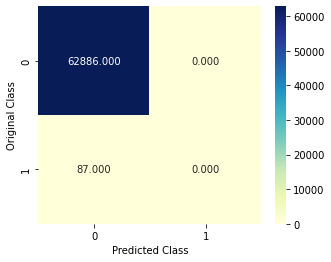

-------------------- Precision matrix (Columm Sum=1) --------------------


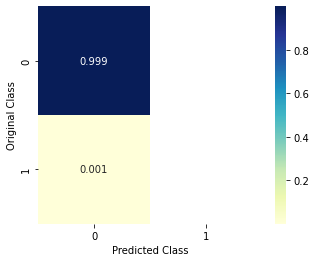

-------------------- Recall matrix (Row sum=1) --------------------


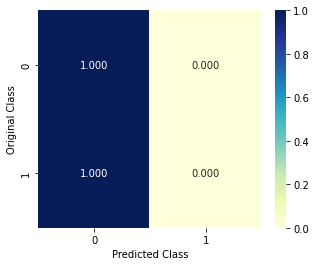

In [258]:
plot_confusion_matrix(y_test,test_pred)

### 9.3 Appling Appling Random Forest Classifier

#### Hyper parameter Tuning

In [264]:
rf=RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1)
param_grid= {'n_estimators': [30, 50, 100,200], 'max_depth': [5, 10, 15]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

clf=GridSearchCV(rf, param_grid, scoring='roc_auc', cv=cv, verbose=1, return_train_score=True, n_jobs=-1)

clf.fit(X_tr, y_train)

best_hyperparameter = clf.best_params_
rf_hyp = clf.best_params_

print("best hyperparameter for given dataset",best_hyperparameter)
train_auc=clf.cv_results_['mean_train_score']

cv_auc=clf.cv_results_['mean_test_score'] 

print("AUC Score on this hyperparameter: " ,clf.best_score_)

trace1 = go.Scatter3d(x=param_grid['n_estimators'] ,y=param_grid['max_depth'], z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=param_grid['n_estimators'] ,y=param_grid['max_depth'], z=cv_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
plt.show()

Fitting 9 folds for each of 12 candidates, totalling 108 fits
best hyperparameter for given dataset {'max_depth': 5, 'n_estimators': 30}
AUC Score on this hyperparameter:  1.0


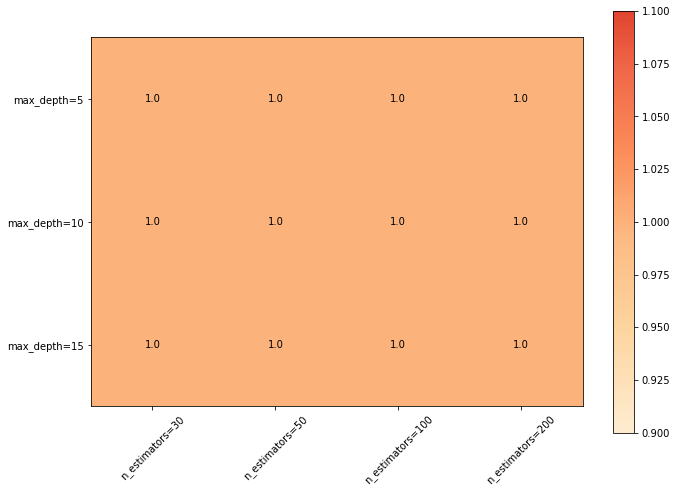

In [265]:
#from sklearn_evaluation import plot
plt.figure(figsize=(10,7))
plot.grid_search(clf.cv_results_, change=("n_estimators", "max_depth"))
plt.show()

#### tested on best hyperparameter on Random Forest Classifier

In [266]:
rf=RandomForestClassifier(criterion='gini', random_state=42, n_estimators=rf_hyp['n_estimators'],max_depth=rf_hyp['max_depth'], n_jobs=-1)
rf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(rf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

# f1_score for train data
train_pred = sig_clf.predict(X_tr)
train_f1_rf = f1_score(y_train, train_pred, average='weighted')
print("train f1_score: ", train_f1_rf)

# f1_score for cv data
cv_pred = sig_clf.predict(X_cr)
cv_f1_rf = f1_score(y_cv, cv_pred, average='weighted')
print("cv f1_score: ", cv_f1_rf)

# f1_score for test data
test_pred = sig_clf.predict(X_te)
test_f1_rf = f1_score(y_test, test_pred, average='weighted')
print("test f1_score: ", test_f1_rf)

train f1_score:  1.0
cv f1_score:  0.9979384704777803
test f1_score:  0.9979281607889625


-------------------- Confusion matrix --------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in true_divide



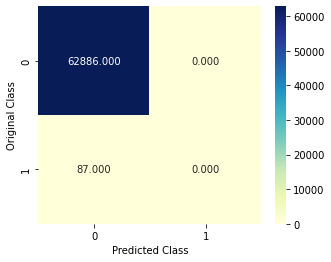

-------------------- Precision matrix (Columm Sum=1) --------------------


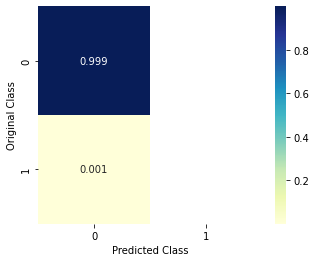

-------------------- Recall matrix (Row sum=1) --------------------


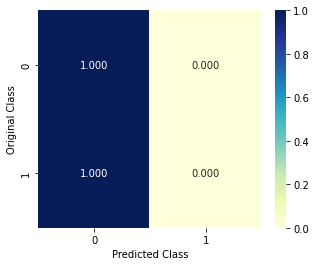

In [267]:
plot_confusion_matrix(y_test,test_pred)

In [294]:
# this feature structure has been used to assemble all features

# X_tr = hstack((np.array(X_train['step']).reshape(-1,1), 
#               X_train_type_ohe, 
#               X_train_amount_norm, 
#               np.array(nameOrig_tr_class1).reshape(-1,1), 
#               np.array(nameOrig_tr_class0).reshape(-1,1), 
#               X_train_oldbalanceOrig_norm, 
#               X_train_newbalanceOrig_norm,
#               np.array(nameDest_tr_class1).reshape(-1,1), 
#               np.array(nameOrig_tr_class0).reshape(-1,1),
#               X_train_oldbalanceDest_norm, 
#               X_train_newbalanceDest_norm, 
#               np.array(X_train['isFlaggedFraud']).reshape(-1,1), 
#               X_train_amount_deduct_from_Orig_norm,
#               X_train_amount_expect_after_successful_transfer_norm)).tocsr()

In [297]:
# as we can see feature which is in 7th index is more important by RandomForestClassifier, which is nameDest_tr_class1

(rf.feature_importances_).argsort()[::-1]

array([ 7, 11,  8, 12, 16,  0,  1,  9,  3,  5, 10,  4, 13, 14, 15,  6,  2,
       17])

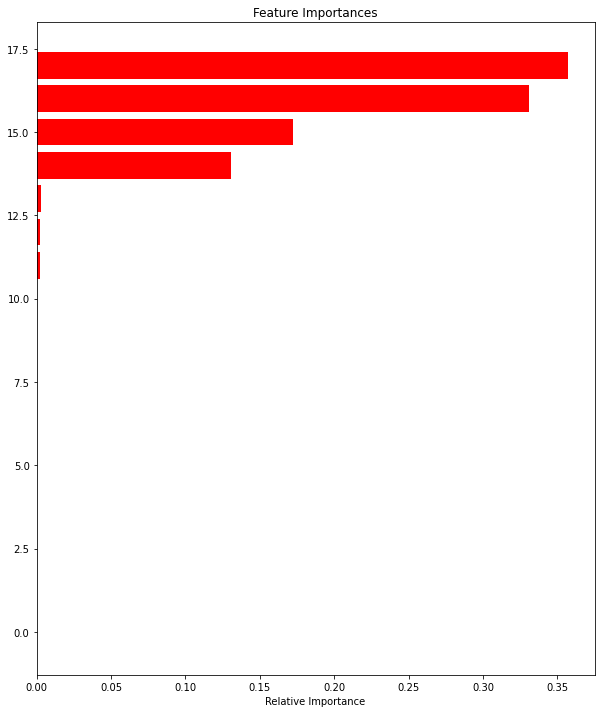

In [292]:
#features = df_final_train.columns
importances = rf.feature_importances_
indices = (np.argsort(importances))[-18:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
#plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 9.4 Appling XGBClassifier

#### Hyper parameter Tuning

In [300]:
import plotly.offline as offline
import plotly.graph_objs as go

In [306]:
# with X-axis as n_estimators, Y-axis as learning_rate, and Z-axis as AUC Score 

xgb = XGBClassifier()

parameters = {'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [5,10,50, 100, 200]}

clf = GridSearchCV(xgb, parameters, cv= 5, scoring='roc_auc', return_train_score = True,n_jobs = -1)


clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 


xgb_hyp = clf.best_params_

print("best hyperparameter: ", clf.best_params_)
print("AUC Score on this hyperparameter: " ,clf.best_score_)

trace1 = go.Scatter3d(x=parameters['n_estimators'] ,y=parameters['learning_rate'], z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=parameters['n_estimators'] ,y=parameters['learning_rate'], z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='learning_rate'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
#fig.show()
plt.show()

best hyperparameter:  {'learning_rate': 0.001, 'n_estimators': 5}
AUC Score on this hyperparameter:  1.0


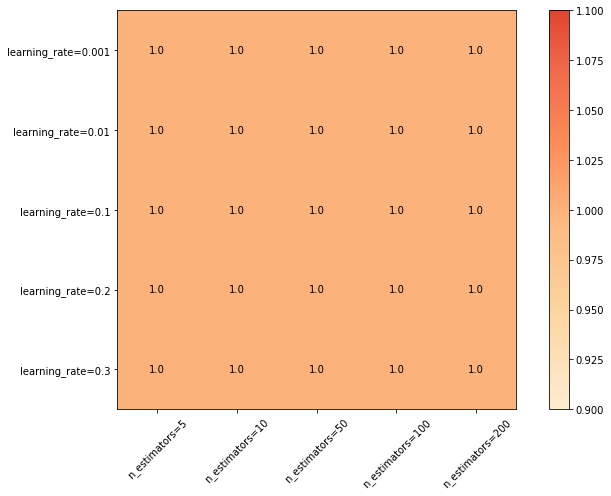

In [307]:
#from sklearn_evaluation import plot
plt.figure(figsize=(10,7))
plot.grid_search(clf.cv_results_, change=("n_estimators", "learning_rate"))
plt.show()

#### ested on best hyperparameter on XGBClassifier

In [308]:
xgb = XGBClassifier(learning_rate=xgb_hyp['learning_rate'], n_estimators=xgb_hyp['n_estimators'])
xgb.fit(X_tr, y_train)

# f1_score for train data
train_pred = xgb.predict(X_tr)
train_f1_xgb = f1_score(y_train, train_pred, average='weighted')
print("train f1_score: ", train_f1_xgb)

# f1_score for cv data
cv_pred = xgb.predict(X_cr)
cv_f1_xgb = f1_score(y_cv, cv_pred, average='weighted')
print("cv f1_score: ", cv_f1_xgb)

# f1_score for test data
test_pred = xgb.predict(X_te)
test_f1_xgb = f1_score(y_test, test_pred, average='weighted')
print("test f1_score: ", test_f1_xgb)

train f1_score:  1.0
cv f1_score:  5.1175552384774624e-05
test f1_score:  6.732945059087132e-05


#### Confusion matrix, precision matrix and recall matrix

-------------------- Confusion matrix --------------------


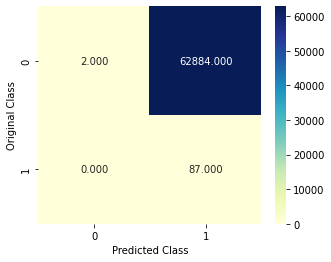

-------------------- Precision matrix (Columm Sum=1) --------------------


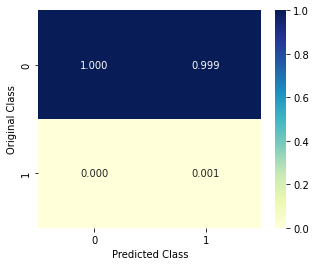

-------------------- Recall matrix (Row sum=1) --------------------


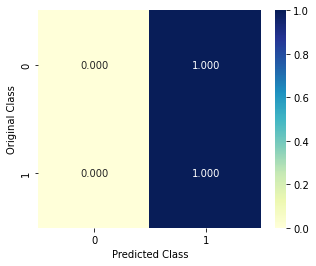

In [309]:
plot_confusion_matrix(y_test,test_pred)

## Summary

In [310]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Hyperparameter", "f1_score"]

x.add_row(["Logistic Regressin", best_C, test_f1_lr])
x.add_row(["Multinomial Naive Bayes", nb_hyp, test_f1_nb])
x.add_row(["RandomForestClassifier", rf_hyp, test_f1_rf])
x.add_row(["XGBClassifier", xgb_hyp, test_f1_xgb])
print(x)

+-------------------------+---------------------------------------------+-----------------------+
|          Model          |                Hyperparameter               |        f1_score       |
+-------------------------+---------------------------------------------+-----------------------+
|    Logistic Regressin   |                     0.01                    |   0.9979281607889625  |
| Multinomial Naive Bayes |                    1e-05                    |   0.9979281607889625  |
|  RandomForestClassifier |     {'max_depth': 5, 'n_estimators': 30}    |   0.9979281607889625  |
|      XGBClassifier      | {'learning_rate': 0.001, 'n_estimators': 5} | 6.732945059087132e-05 |
+-------------------------+---------------------------------------------+-----------------------+


# On seeing above criteria regarding Fraud Detection following points are concluded

<b>1. Data cleaning including missing values, outliers and multi-collinearity.</b>

The given dataset has not contain any missing value.

Data cleaing has been done on above mentioned steps, here I have used percentile and some 2D plot to see clearly the outliers.

multi-collinearity has been checked by df.corr() method using heatmap.

<b>2. Describe your fraud detection model in elaboration.</b>

Here I have used total 6 machine learning models(Logistic Regressin, Multinomial Naive Bayes, RandomForestClassifier, XGBClassifier) to see clearly which model performs well in this context.
After applying these model we can see taht Logistic Regression, Multinomial Naive Bayes, RandomForestClassifier has give almost 99% accuracy as F1_Score, but XGBoostClassifier has been overfitted and performas really bad on newly unseen test data, so, we should avoid XGBoostClassifier in this case.

Since this is a binary classification problem, we could use the following 2 popular metrics:

* Confusion matrix, Precision matrix, Recall matrix
* f1_score

<b>3. How did you select variables to be included in the model?</b>

Here in this context for encoding Categorical variable <b>*nameOrig*</b> and <b>*nameDest*</b> I have used Response coding and other Categorical variable I have used onehot encoding technique using CountVectorizer().

For encoding neumerical variable I have used Normalizer() to normalize the value except <b>*step*</b> variable, because step maps a unit of time in the real world.

<b>4. Demonstrate the performance of the model by using best set of tools.</b>

As this is mentioned inside summery section,

* Logistic Regressin- F1_Score: 0.99
* Multinomial Naive Bayes- F1_Score: 0.99
* RandomForestClassifier- F1_Score: 0.99
* XGBClassifier- F1_Score: 6.73e-05 (bad performance)


<b>5. What are the key factors that predict fraudulent customer?</b>

Key factors as the feature importance, which is given by RandomForestClassifier.
Most important feature is nameDest, then second important feature is isFlaggedFraud, then nameOrig.

<b>6. Do these factors make sense? If yes, How? If not, How not?</b>

As we have seen that on the base line prespective, 
* if <b>*newbalanceOrig*=0.0</b> there is  98.05 % chance of is_Fraud=1 given total number of is_Fraud=1

* if <b>*oldbalanceDest*=0.0</b> there is  65.15 % chance of is_Fraud=1 given total number of is_Fraud=1

* if <b>*newbalanceDest*=0.0</b> there is  49.81 % chance of is_Fraud=1 given total number of is_Fraud=1

* if <b>*type*=CASH_OUT</b> there is  50.12 % chance of is_Fraud=1 given total number of is_Fraud=1

* if <b>*type*=TRANSFER</b> there is  49.88 % chance of is_Fraud=1 given total number of is_Fraud=1



<b>7. What kind of prevention should be adopted while company update its infrastructure?</b>

From the base line prespective if variable <b>*newbalanceOrig*=0.0</b>, there might be high chance of isFraud=1, because fraudulent agents are tries to empty the funds by transferring to another account.

<b>8. Assuming these actions have been implemented, how would you determine if they work?</b>

If this is implemented and deploed into server, then we can choose either Logistic Regressin or Multinomial Naive Bayes or RandomForestClassifier but should avoid XGBClassifier because this is too much overfitted.



